# RNNs

Includes RNNs and models that require NVIDIA GPUs to run.

TODO:

- [ ] I included a feature to save the model to disk for most models, but some of them do not have it. So be mindful of that
- [ ] includes uncertainty band in prediction

# Initialize

## Packages

### General

In [1]:
import os, sys
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from importlib import reload

Save data to Google Drive

In [2]:
try:
    from google.colab import drive
    drive.mount('/content/drive/')
    print("Running in Google Colab")
    in_colab=True
except:
    print("Running locally")
    in_colab=False

Mounted at /content/drive/
Running in Google Colab


Formatting

In [3]:
# For ASCII plots of training progress
try:
    import asciichartpy
except ImportError:
    !pip install asciichartpy
    import asciichartpy

from IPython.display import clear_output

### ML

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import copy

Enables GPU support

In [5]:
if not torch.cuda.is_available():
    print("No GPU was detected. Neural nets can be very slow without a GPU.")
    if "google.colab" in sys.modules:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if "kaggle_secrets" in sys.modules:
        print("Go to Settings > Accelerator and select GPU.")
else:
    # Iterate through all available GPU devices and print their names.
    for idx in range(torch.cuda.device_count()):
        print(f"Device Name: {torch.cuda.get_device_name(idx)}")

Device Name: Tesla T4


In [6]:
import pandas as pd

## Helper functions

Here we define a couple of helper functions that we will reuse several times. Most of magic happens inside `my_functions.py`.

In [7]:
if in_colab:
  sys.path.append('/content/drive/MyDrive/Colab Notebooks/pytorch')

import my_functions as mine

In [8]:
# Computes MAE for two numpy arrays
maef = lambda y_pred, data: (y_pred - data).abs().mean()

Align the phase: helper function

In [9]:
def align_phase(ts, dt=-1):
  """
  Returns a pandas time series object.
  """
  # shift the TS by -1 day
  values_shift=np.roll(ts, dt)

  # create a pandas TS
  return pd.Series(values_shift, index=ts.index)

# Data



## Get data

In [10]:
!wget https://github.com/ageron/data/raw/main/ridership.tgz
!mkdir data
!mv ridership.tgz data
!tar -xvzf data/ridership.tgz --directory=data/

--2025-04-09 19:19:11--  https://github.com/ageron/data/raw/main/ridership.tgz
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ageron/data/main/ridership.tgz [following]
--2025-04-09 19:19:12--  https://raw.githubusercontent.com/ageron/data/main/ridership.tgz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 108512 (106K) [application/octet-stream]
Saving to: ‘ridership.tgz’

ridership.tgz       100%[===================>] 105.97K  --.-KB/s    in 0.002s  

2025-04-09 19:19:12 (51.6 MB/s) - ‘ridership.tgz’ saved [108512/108512]

ridership/
ridership/CTA_-_Ridership_-_Daily_Boarding_Totals.csv


In [11]:
# read data
path = Path("data/ridership/CTA_-_Ridership_-_Daily_Boarding_Totals.csv")
df = pd.read_csv(path, parse_dates=["service_date"])

# some cleaning
df.columns = ["date", "day_type", "bus", "rail", "total"]  # shorter names
df = df.sort_values("date").set_index("date")
df = df.drop("total", axis=1)  # no need for total, it's just bus + rail
df = df.drop_duplicates()  # remove duplicated months (2011-10 and 2014-07)

## Preparing data for ML models

Our goal will be to forecast tomorrow’s ridership based
on the ridership of the past 8 weeks of data (56 days). The inputs to our model
will therefore be sequences (usually a single sequence per day once the model is in
production), each containing 56 values from time steps $t – 55$ to $t$. For each input
sequence, the model will output a single value: the forecast for time step $t + 1$.

Before we continue looking at the data, let's **split the time series into three periods, for training, validation and testing**. We won't look at the test data for now:

In [12]:
rail_train = df["rail"]["2016-01":"2018-12"] / 1e6
rail_valid = df["rail"]["2019-01":"2019-05"] / 1e6
rail_test = df["rail"]["2019-06":] / 1e6

Blue is training, orange if validation, green is test

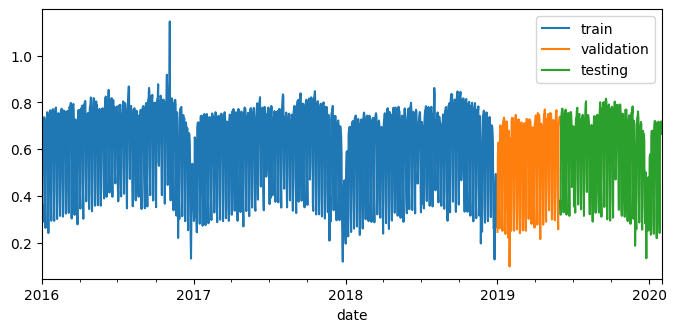

In [13]:
rail_train.plot(figsize=(8, 3.5), label='train')
rail_valid.plot(label='validation')
rail_test[:'2020-1'].plot(label='testing') # excludes the pandemic
plt.legend()
plt.show()

## Preps for pytorch

Training and validation data

In [14]:
# For reproducibility
torch.manual_seed(42)
np.random.seed(42)

class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_length):
        self.data = data
        self.seq_length = seq_length

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, idx):
        # Get sequence
        sequence = self.data[idx:idx+self.seq_length]
        # Get target (next value after sequence)
        target = self.data[idx+self.seq_length]
        return torch.tensor(sequence, dtype=torch.float32), torch.tensor(target, dtype=torch.float32)

In [15]:
# Convert rail_train to numpy array
data_array = rail_train.to_numpy()

# Create dataset
seq_length = 56
dataset = TimeSeriesDataset(data_array, seq_length)

# For reproducibility when shuffling
g = torch.Generator()
g.manual_seed(42)

In [16]:
# Create dataloader with shuffling and batching (train_ds)
train_loader = DataLoader(
    dataset,
    batch_size=32,
    shuffle=True,
    generator=g,
    drop_last=False
)

# Create validation dataset using the same TimeSeriesDataset class
valid_data_array = rail_valid.to_numpy()
valid_dataset = TimeSeriesDataset(valid_data_array, seq_length)

# Create validation dataloader (no shuffling needed for validation) (valid_ds)
valid_loader = DataLoader(
    valid_dataset,
    batch_size=32,
    shuffle=False,
    drop_last=False
)

# RNN



## One recursive neuron

Checks whether the model was already trained and saved to disk, if not performs the training

keras-equivalent code:

```python
if not os.path.exists(model_file): # train
    # defines model
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(None, 1)),  # Define the input shape explicitly
        tf.keras.layers.SimpleRNN(1)
    ])
```

In [17]:
class SimpleRNNModel(nn.Module):
    def __init__(self):
        super(SimpleRNNModel, self).__init__()
        self.rnn = nn.RNN(input_size=1, hidden_size=1, batch_first=True)

    def forward(self, x):
        # x shape: (batch_size, seq_length, input_size=1)
        _, h_n = self.rnn(x)
        # h_n shape: (num_layers=1, batch_size, hidden_size=1)
        return h_n.squeeze(0)  # shape: (batch_size, hidden_size=1)

# Create an instance of the model
model = SimpleRNNModel()

In [18]:
if in_colab:
  os.makedirs('/content/drive/MyDrive/Colab Notebooks/pytorch/models/', exist_ok=True)
else:
  os.makedirs(Path() / "models", exist_ok=True)

In [19]:
%time mine.train_save(model, in_colab, "rnn-1n.pth", train_loader, valid_loader, 0.02, mine.fit_and_evaluate)

Loading weights from disk
CPU times: user 7.24 ms, sys: 4.18 ms, total: 11.4 ms
Wall time: 664 ms


Get the forecast

In [20]:
y_1n=mine.get_forecast(seq_length, rail_valid, model)

In [21]:
mae_1n=maef(y_1n, rail_valid[y_1n.index])*1e6
print(mae_1n)

133759.1406023553


<ipython-input-22-71032f513481>:3: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  ax.plot(y_1n, marker=".", label="1 neuron")


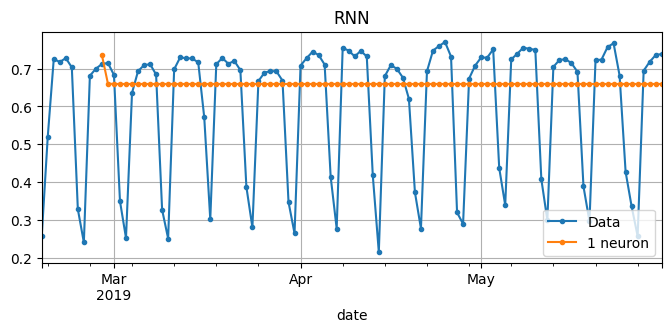

In [22]:
fig, ax = plt.subplots(figsize=(8, 3))
rail_valid.loc[y_1n.index[0]-pd.Timedelta(days=10):rail_valid.index[-1]].plot(label="Data", ax=ax, marker=".", grid=True)
ax.plot(y_1n, marker=".", label="1 neuron")
plt.legend(fontsize=10, loc='lower right')
plt.title("RNN")
plt.show()

### Analysis

Why is the performance abysmal?

**Underfitting**

The model only has a single recurrent neuron, so the only data it can use to
make a prediction at each time step is the input value at the current time step
and the output value from the previous time step. In
other words, the RNN’s memory is just a single number,
its previous output.

How many parameters this model has? Since
there’s just one recurrent neuron with only two input values, the whole model
only has three parameters (two weights plus a bias term). That’s far from enough
for this time series. In contrast, our previous model could look at all 56 previous
values at once, and it had a total of 57 parameters.

**Lack of proper normalization**

The time series contains values from 0 to about 1.4, but since the default activation function is tanh, the recurrent layer can only output values between –1 and +1. There’s no way it can predict values between 1.0 and 1.4.

## 32 recurrent neurons

Recurrent layer, containing 32 recurrent neurons. We add a dense output layer on top of it with a single output neuron and no activation function. The recurrent layer will be able to carry much more information from one time step to the next, and the dense output layer will project the final output from 32 dimensions down to 1, without any value range constraints.

Keras-equivalent code:

```python
    # defines model
    univar_model = tf.keras.Sequential([
        tf.keras.Input(shape=[None, 1]),  # Define the input shape explicitly
        tf.keras.layers.SimpleRNN(32),
        tf.keras.layers.Dense(1)  # No activation function by default
    ])
```

In [23]:
class UnivarModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=32, output_size=1):
        super(UnivarModel, self).__init__()

        # Equivalent to SimpleRNN(32)
        self.rnn = nn.RNN(
            input_size=input_size,     # Feature dimension (1 for univariate)
            hidden_size=hidden_size,   # Number of RNN units (32)
            batch_first=True,          # Input shape is [batch, seq, feature]
            nonlinearity='tanh'        # Default activation for SimpleRNN
        )

        # Equivalent to Dense(1)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x shape: [batch_size, seq_length, input_size]

        # RNN returns: output, h_n
        # output shape: [batch_size, seq_length, hidden_size]
        # h_n shape: [1, batch_size, hidden_size]
        _, h_n = self.rnn(x)

        # Use the final hidden state
        # Reshape h_n: [1, batch_size, hidden_size] -> [batch_size, hidden_size]
        h_n = h_n.squeeze(0)

        # Apply linear layer
        output = self.linear(h_n)

        return output

# Create an instance of the model
model = UnivarModel(input_size=1, hidden_size=32, output_size=1)

In [24]:
%time mine.train_save(model, in_colab, "rnn-32n.pth", train_loader, valid_loader, 0.05, mine.fit_and_evaluate)

Loading weights from disk
CPU times: user 7.14 ms, sys: 158 µs, total: 7.29 ms
Wall time: 665 ms


In [25]:
%%time
y_32n=mine.get_forecast(seq_length, rail_valid, model)

CPU times: user 132 ms, sys: 2.19 ms, total: 134 ms
Wall time: 306 ms


In [26]:
mae_32n=maef(y_32n, rail_valid[y_32n.index])*1e6
print(mae_32n)

131804.90912707307


<ipython-input-27-a9cae016e86b>:3: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  ax.plot(y_32n, marker=".", label="32 neurons")


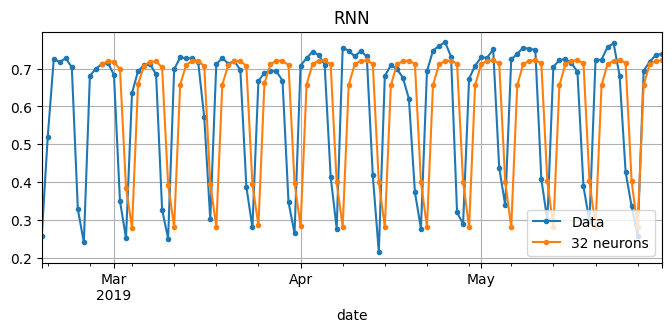

In [27]:
fig, ax = plt.subplots(figsize=(8, 3))
rail_valid.loc[y_32n.index[0]-pd.Timedelta(days=10):rail_valid.index[-1]].plot(label="Data", ax=ax, marker=".", grid=True)
ax.plot(y_32n, marker=".", label="32 neurons")
plt.legend(fontsize=10, loc='lower right')
plt.title("RNN")
plt.show()

### Aligning the phase

As I said in the previous notebook, the model can't know if the starting time for the forecast is in the beginning, middle or end of a period. Let's shift the forecast by one day and see how that impacts the MAE.

In [28]:
# shift the TS by -1 day
values_shift=np.roll(y_32n, -1)

# create a pandas TS
ts_shift=pd.Series(values_shift, index=y_32n.index)

<ipython-input-29-33b74e8fc46d>:3: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  ax.plot(ts_shift, marker=".", label="32 neurons")


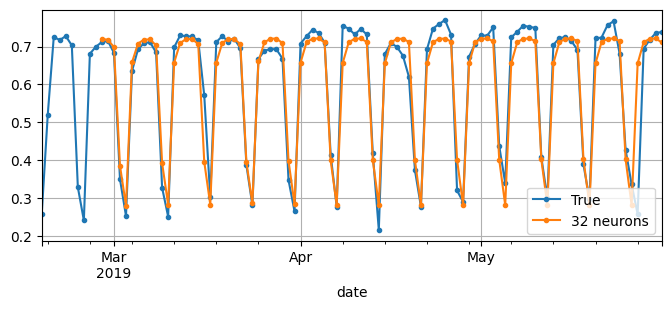

In [29]:
fig, ax = plt.subplots(figsize=(8, 3))
rail_valid.loc[y_32n.index[0]-pd.Timedelta(days=10):rail_valid.index[-1]].plot(label="True", ax=ax, marker=".", grid=True)
ax.plot(ts_shift, marker=".", label="32 neurons")
plt.legend(fontsize=10, loc='lower right')
plt.show()

In [30]:
# recompute MAE
maef(ts_shift, rail_valid[ts_shift.index])*1e6

np.float64(31531.927840841585)

# Deep RNNs

Keras-equivalent code:

```python
deep_model = tf.keras.Sequential([
  tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 1]),
  tf.keras.layers.SimpleRNN(32, return_sequences=True),
  tf.keras.layers.SimpleRNN(32),
  tf.keras.layers.Dense(1)
])
```

In [33]:
class DeepRNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=32, output_size=1):
        super(DeepRNN, self).__init__()

        # First RNN layer
        self.rnn1 = nn.RNN(input_size=input_size, hidden_size=hidden_size, batch_first=True, nonlinearity='tanh')
        # Second RNN layer
        self.rnn2 = nn.RNN(input_size=hidden_size, hidden_size=hidden_size, batch_first=True, nonlinearity='tanh')
        # Third RNN layer
        self.rnn3 = nn.RNN(input_size=hidden_size, hidden_size=hidden_size, batch_first=True, nonlinearity='tanh')
        # Output layer
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        output1, _ = self.rnn1(x)
        output2, _ = self.rnn2(output1)
        _, h_n = self.rnn3(output2)
        h_n = h_n.squeeze(0)
        output = self.linear(h_n)

        return output

# Create an instance of the model
deep_model = DeepRNN(input_size=1, hidden_size=32, output_size=1)

In [34]:
%time mine.train_save(deep_model, in_colab, "rnn-deep.pth", train_loader, valid_loader, 0.01, mine.fit_and_evaluate)

Epoch 303/500, Validation MAE: 0.033042
   -0.82  ┤
   -0.88  ┤
   -0.95  ┤
   -1.02  ┤
   -1.08  ┤
   -1.15  ┤
   -1.21  ┤
   -1.28  ┤
   -1.34  ┤
   -1.41  ┤  ╭╮  ╭╮  ╭─╮╭─────╮╭╮      ╭─╮        ╭╮ ╭╮╭╮╭╮  ╭╮      ╭╮    ╭─╮ ╭╮ ╭╮ ╭╮  ╭─╮╭╮ ╭╮╭╮  ╭╮ ╭──╮ ╭
   -1.48  ┼──╯╰──╯╰──╯ ╰╯     ╰╯╰──────╯ ╰────────╯╰─╯╰╯╰╯╰──╯╰──────╯╰────╯ ╰─╯╰─╯╰─╯╰──╯ ╰╯╰─╯╰╯╰──╯╰─╯  ╰─╯
   -1.54  ┤
Early stopping triggered at epoch 303
Saving weights to disk
CPU times: user 3min 53s, sys: 656 ms, total: 3min 54s
Wall time: 4min 3s


Forecast

In [36]:
y_deep=mine.get_forecast(seq_length, rail_valid, deep_model)

Phase alignment

In [37]:
y_deep_aligned=align_phase(y_deep)

<ipython-input-38-c741ce7764cd>:3: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  ax.plot(y_deep_aligned, marker=".", label="Deep RNN")


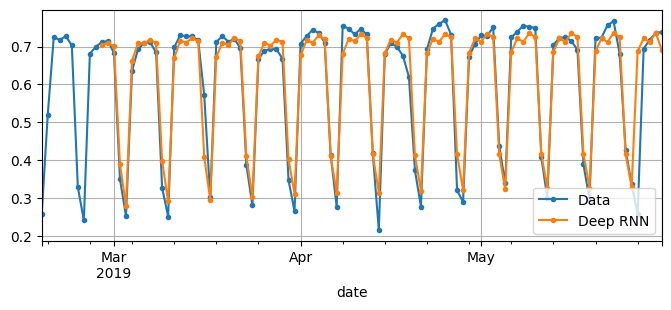

In [38]:
fig, ax = plt.subplots(figsize=(8, 3))
rail_valid.loc[y_deep.index[0]-pd.Timedelta(days=10):rail_valid.index[-1]].plot(label="Data", ax=ax, marker=".", grid=True)
ax.plot(y_deep_aligned, marker=".", label="Deep RNN")
plt.legend(fontsize=10, loc='lower right')
plt.show()

In [39]:
mae_deep=maef(y_deep_aligned, rail_valid[y_deep_aligned.index])*1e6
print(mae_deep)

30548.24354518728


# Multivariate TS

Defines the dataframe and features. Now `df_mulvar` is a DataFrame with five columns: the bus and rail data, plus three
columns containing the one-hot encoding of the next day’s type (recall that there are
three possible day types, W, A, and U).

In [40]:
df_mulvar = df[["bus", "rail"]] / 1e6  # use both bus & rail series as input
df_mulvar["next_day_type"] = df["day_type"].shift(-1)  # we know tomorrow's type
df_mulvar = pd.get_dummies(df_mulvar, dtype=int)  # one-hot encode the day type

In [41]:
df_mulvar.head()

,bus,rail,next_day_type_A,next_day_type_U,next_day_type_W
date,,,,,
2001-01-01,0.297192,0.126455,0,0,1
2001-01-02,0.780827,0.501952,0,0,1
2001-01-03,0.824923,0.536432,0,0,1
2001-01-04,0.870021,0.550011,0,0,1
2001-01-05,0.890426,0.557917,1,0,0


Next we can proceed much like we did earlier.
First we split the data into three periods, for training, validation, and testing:

In [42]:
mulvar_train = df_mulvar["2016-01":"2018-12"]
mulvar_valid = df_mulvar["2019-01":"2019-05"]
mulvar_test = df_mulvar["2019-06":]

## Forecasts one variable

$$y = f(\mathbf{x})$$
where $\mathbf{x}$ encodes the features used for training—in this case, bus riders, rail riders, and whether the next day is a weekday, Saturday or Sunday (which are, of course, mutually exclusive).

In [43]:
mulvar_train.to_numpy()

array([[0.303321, 0.319835, 1.      , 0.      , 0.      ],
       [0.448859, 0.365509, 0.      , 1.      , 0.      ],
       [0.34054 , 0.287661, 0.      , 0.      , 1.      ],
       ...,
       [0.394088, 0.307105, 0.      , 1.      , 0.      ],
       [0.31455 , 0.26531 , 0.      , 0.      , 1.      ],
       [0.463165, 0.386058, 0.      , 1.      , 0.      ]])

Prepares data for training


In [44]:
# Custom dataset for time series
class TimeSeriesDatasetMulvar(Dataset):
    def __init__(self, data, targets, seq_length):
        self.data = data
        self.targets = targets
        self.seq_length = seq_length

    def __len__(self):
        return len(self.targets)  # Should match len(data) - seq_length

    def __getitem__(self, idx):
        # Get sequence from data
        X = self.data[idx:idx + self.seq_length]
        # Get corresponding target
        y = self.targets[idx]
        return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# Create datasets
train_data = mulvar_train.to_numpy()
train_targets = mulvar_train["rail"].values[seq_length:]
train_dataset = TimeSeriesDatasetMulvar(train_data, train_targets, seq_length)
train_loader_mulvar = DataLoader(train_dataset, batch_size=32, shuffle=True, generator=torch.Generator().manual_seed(42))

valid_data = mulvar_valid.to_numpy()
valid_targets = mulvar_valid["rail"].values[seq_length:]
valid_dataset = TimeSeriesDatasetMulvar(valid_data, valid_targets, seq_length)
valid_loader_mulvar = DataLoader(valid_dataset, batch_size=32, shuffle=False)


Define the model. Notice that the input shape takes five inputs—one for each feature—instead of one.

In [45]:
# Define the model
class MulvarRNN(nn.Module):
    def __init__(self):
        super(MulvarRNN, self).__init__()
        self.rnn = nn.RNN(5, 32, batch_first=True)
        self.linear = nn.Linear(32, 1)

    def forward(self, x):
        _, hidden = self.rnn(x)
        return self.linear(hidden.squeeze(0))

# Initialize model
mulvar_model1 = MulvarRNN()

Train and save the model.

In [46]:
%time mine.train_save(mulvar_model1, in_colab, "mulvar1.pth", train_loader_mulvar, valid_loader_mulvar, 0.05, mine.fit_and_evaluate_mulvar)

Loading weights from disk
CPU times: user 6.36 ms, sys: 991 µs, total: 7.35 ms
Wall time: 769 ms


Spits out forecast

In [47]:
y1_mulvar=mine.get_forecast_mulvar(seq_length, mulvar_valid, mulvar_model1, 'rail')

<ipython-input-48-590d6bf58da5>:3: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  ax.plot(y1_mulvar, marker=".", label="Model")


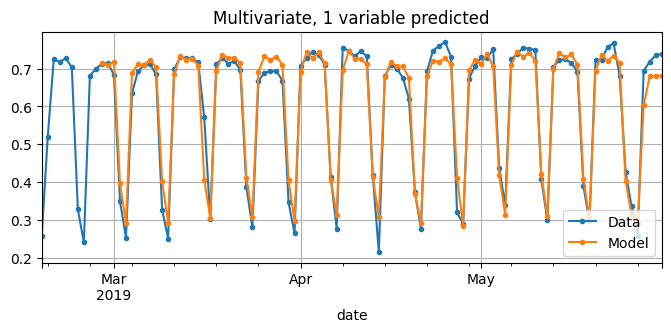

In [48]:
fig, ax = plt.subplots(figsize=(8, 3))
rail_valid.loc[y1_mulvar.index[0]-pd.Timedelta(days=10):rail_valid.index[-1]].plot(label="Data", ax=ax, marker=".", grid=True)
ax.plot(y1_mulvar, marker=".", label="Model")
plt.legend(fontsize=10, loc='lower right')
plt.title('Multivariate, 1 variable predicted')
plt.show()

Notice that using more variables for prediction fixes the day offset, because now the model knows when the week starts.

In [49]:
mae_mulvar1=maef(y1_mulvar, rail_valid[y1_mulvar.index])*1e6
print(mae_mulvar1)

25840.021754386577


## Forecasts two variables

$$\mathbf{y} = (y_0, y_1) = \mathbf{f}(\mathbf{x})$$

Splits into training and validation

In [50]:
# Custom dataset for time series with multiple targets
class TimeSeriesDatasetMulvar2(Dataset):
    def __init__(self, data, target_cols, seq_length):
        """
        data: pandas DataFrame containing all features
        target_cols: list of column names to predict (e.g., ['bus', 'rail'])
        seq_length: length of input sequence
        """
        self.data = data.values  # Convert to numpy for faster indexing
        self.seq_length = seq_length

        # Get column indices for targets
        self.target_indices = [data.columns.get_loc(col) for col in target_cols]

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, idx):
        # Get sequence from data
        X = self.data[idx:idx + self.seq_length]
        # Get target values at the next time step after the sequence
        y = self.data[idx + self.seq_length, self.target_indices]
        return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

In [51]:
# Create datasets
train_dataset = TimeSeriesDatasetMulvar2(data=mulvar_train, target_cols=["bus", "rail"], seq_length=seq_length)
train_loader_mulvar2 = DataLoader(train_dataset, batch_size=32, shuffle=True, generator=torch.Generator().manual_seed(42))

valid_dataset = TimeSeriesDatasetMulvar2(data=mulvar_valid, target_cols=["bus", "rail"], seq_length=seq_length)
valid_loader_mulvar2 = DataLoader(valid_dataset, batch_size=32, shuffle=False)

Defines model

In [52]:
# Define the model
class MulvarRNN2(nn.Module):
    def __init__(self):
        super(MulvarRNN2, self).__init__()
        self.rnn = nn.RNN(5, 32, batch_first=True)
        self.linear = nn.Linear(32, 2)

    def forward(self, x):
        _, hidden = self.rnn(x)
        return self.linear(hidden.squeeze(0))

# Initialize model
mulvar_model2 = MulvarRNN2()

Training

In [53]:
%time mine.train_save(mulvar_model2, in_colab, "mulvar2.pth", train_loader_mulvar2, valid_loader_mulvar2, 0.02, mine.fit_and_evaluate_mulvar)

Loading weights from disk
CPU times: user 7.19 ms, sys: 1 ms, total: 8.2 ms
Wall time: 784 ms


In [55]:
y2_mulvar=mine.get_forecast_mulvar(seq_length, mulvar_valid, mulvar_model2, ['bus','rail'])

In [56]:
y2_mulvar.head()

,bus,rail
2019-02-27,0.781240,0.709015
2019-02-28,0.773079,0.707018
2019-03-01,0.766761,0.710701
2019-03-02,0.447515,0.402482
2019-03-03,0.321688,0.294335


In [57]:
bus_valid = df["bus"]["2019-01":"2019-05"] / 1e6

<ipython-input-58-dd0fc5f7c2a3>:4: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  ax1.plot(y2_mulvar['rail'], marker=".", label="Model")
<ipython-input-58-dd0fc5f7c2a3>:8: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  ax2.plot(y2_mulvar['bus'], marker=".", label="Model", color='red')


Text(0.5, 0.98, 'Multivariate, 2 variables predicted')

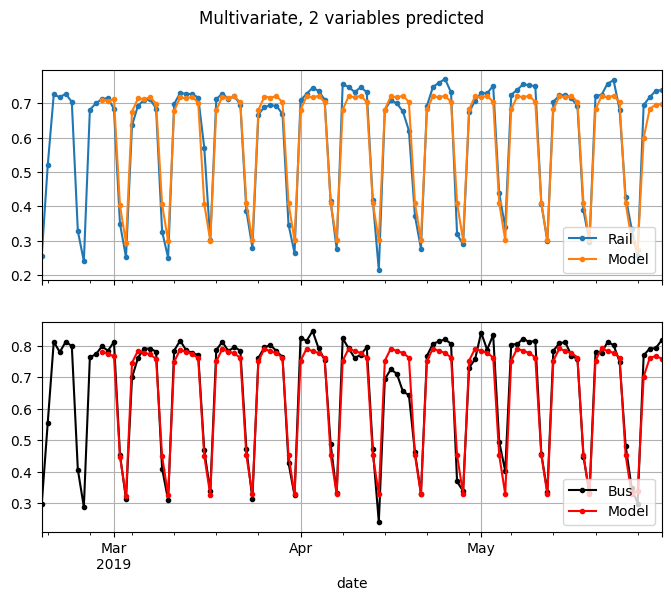

In [58]:
fig, (ax1, ax2) = plt.subplots(figsize=(8, 6), nrows=2, sharex=True)

rail_valid.loc[y2_mulvar.index[0]-pd.Timedelta(days=10):rail_valid.index[-1]].plot(ax=ax1, label="Rail", marker=".", grid=True)
ax1.plot(y2_mulvar['rail'], marker=".", label="Model")
ax1.legend(fontsize=10, loc='lower right')

bus_valid.loc[y2_mulvar.index[0]-pd.Timedelta(days=10):rail_valid.index[-1]].plot(ax=ax2, label="Bus", marker=".", grid=True, color='black')
ax2.plot(y2_mulvar['bus'], marker=".", label="Model", color='red')
ax2.legend(fontsize=10, loc='lower right')

fig.suptitle('Multivariate, 2 variables predicted')

Evaluates the naive forecasts for bus

In [59]:
bus_naive = mulvar_valid["bus"].shift(7)[seq_length:]
bus_target = mulvar_valid["bus"][seq_length:]
(bus_target - bus_naive).abs().mean() * 1e6

np.float64(43441.63157894738)

Evaluates the multitask RNN's forecasts both bus and rail

In [60]:
mae_rail=maef(y2_mulvar['rail'], rail_valid[y2_mulvar['rail'].index])*1e6
mae_bus=maef(y2_mulvar['bus'], bus_valid[y2_mulvar['bus'].index])*1e6

print("Rail", mae_rail)
print("Bus", mae_bus)

Rail 27647.6146492248
Bus 29027.258285136933


# Forecasting Several Steps Ahead

## Primer

Let's break down the difference between sequence-to-vector (Seq2Vec) and sequence-to-sequence (Seq2Seq) models.

### Sequence-to-Vector (Seq2Vec) Models

**Input:** A sequence of past time series values (e.g., `[x_t-k, ..., x_t-1, x_t]`).

**Output:** A *single vector*. This vector can represent different things depending on the specific forecasting task:

* **Single-Step Forecast:** The vector might just be a single value, predicting the *very next* time step (`x_t+1`).
* **Multi-Step Forecast (Direct Strategy):** The vector could have a *fixed size*, representing predictions for *multiple* future time steps simultaneously (e.g., `[x_t+1, x_t+2, ..., x_t+h]`). The key here is that all `h` future steps are predicted *at once* from the encoded input sequence.

**Architecture:** Typically involves an "encoder" (like an RNN, LSTM, GRU, or even a Transformer encoder) that reads the input sequence and compresses its information into a final hidden state or context vector. This final vector is then fed into a "decoder," which is often just a simple feed-forward network (Dense layer) that maps the context vector to the desired output vector (either a single value or a fixed-size vector of future values).

**Analogy:** Think of reading a whole paragraph (the input sequence) and summarizing it into a single key takeaway sentence or even just a sentiment score (the output vector).

**Use Case in Time Series:** Good for short-term forecasts or when you need to predict a fixed, relatively small number of steps ahead directly. For example, predicting the stock price for the *next day* based on the last 30 days, or predicting the temperature for the *next 3 hours* based on the last 24 hours.

### Sequence-to-Sequence (Seq2Seq) Models

**Input:** A sequence of past time series values (e.g., `[x_t-k, ..., x_t-1, x_t]`).

**Output:** *Another sequence* of future time series values (e.g., `[x_t+1, x_t+2, ..., x_t+h]`). The crucial difference is that the output is generated *sequentially*, often one step at a time.

**Architecture:** Usually employs a more distinct "encoder-decoder" structure.

*   *Encoder:* Reads the entire input sequence and summarizes it into a context vector (similar to Seq2Vec).
*   *Decoder:* Takes the context vector and *iteratively* generates the output sequence. For time `t+1`, it predicts `x_t+1`. For time `t+2`, it might use the context vector *and* its previous prediction (`x_t+1`) to predict `x_t+2`, and so on. This allows the model to potentially capture dependencies *within* the forecast horizon itself.

**Analogy:** Think of machine translation. The encoder reads a sentence in French (input sequence), creates an internal representation (context vector), and the decoder then generates the translated sentence in English (output sequence), word by word.

**Use Case in Time Series:** Particularly useful for longer-term forecasts where the prediction horizon (`h`) is large or variable. Because it generates outputs step-by-step, it can potentially model the dynamics over the forecast period more effectively than predicting everything at once. For example, predicting the hourly electricity demand for the *entire next week* based on the past month's data.

### Key differences

| Feature             | Sequence-to-Vector (Seq2Vec)                    | Sequence-to-Sequence (Seq2Seq)                      |
| :------------------ | :---------------------------------------------- | :-------------------------------------------------- |
| **Input**           | Sequence of past values                         | Sequence of past values                             |
| **Output**          | Single vector (single future value OR fixed-size vector of multiple future values) | Sequence of future values                           |
| **Generation**      | Output generated *at once* from encoded input | Output generated *sequentially* (step-by-step)      |
| **Forecast Horizon**| Typically better for short, fixed horizons      | More flexible, often preferred for longer horizons |
| **Architecture**    | Encoder -> Dense Layer (often)                  | Encoder -> Decoder (often RNN/LSTM/Transformer based) |
| **Complexity**      | Generally simpler                               | Generally more complex                             |
| **Example Strategy**| Direct Multi-Step Forecasting                 | Recursive (Autoregressive) Multi-Step Forecasting   |

**Key Takeaway**

*   If your goal is to predict just the next step, or a small, fixed number of steps directly, a **Seq2Vec** approach might be sufficient and potentially simpler to implement and train.
*   If you need to predict a longer sequence of future values, and you believe the dynamics *within* that future sequence are important (i.e., the value at `t+2` depends heavily on the predicted value at `t+1`), a **Seq2Seq** model is often the more powerful and appropriate choice, despite its increased complexity.

The choice between them depends heavily on the specific requirements of your forecasting problem, particularly the desired forecast horizon and the nature of the time series dynamics.

## A) sequence-to-vector

We train an RNN to predict the next 14 values in one shot. We
can still use a sequence-to-vector model, but it will output 14 values instead of 1.
However, we first need to change the targets to be vectors containing the next 14
values.

In [61]:
class TSAhead(Dataset):
    def __init__(self, series, history, ahead=14, target_col=1):
        """
        Args:
            series (np.ndarray): the full time series data with shape (num_timesteps, num_features).
            history (int): the number of time steps to use as input (i.e. seq_length).
            ahead (int): the forecast horizon (number of steps ahead).
            target_col (int): the index of the target column (e.g. 1).

        The dataset windows are of length 'history + ahead'. For each window, the first
        'history' time steps become the input features and the following 'ahead' steps (from
        the target column) become the target.
        """
        self.series = series
        self.window_length = history + ahead
        self.history = history
        self.ahead = ahead
        self.target_col = target_col

    def __len__(self):
        # For a series with N timesteps, the number of windows is N - (window_length - 1)
        return len(self.series) - self.window_length + 1

    def __getitem__(self, idx):
        # Extract a window from the series
        window = self.series[idx: idx + self.window_length]
        # Convert to a torch tensor (float32)
        window = torch.tensor(window, dtype=torch.float32)

        # Split the window into:
        # - X: first 'history' steps with all features
        # - y: last 'ahead' steps for the target column
        X = window[:self.history, :]
        y = window[self.history:, self.target_col]
        return X, y

ahead = 14       # forecast horizon

train_series = mulvar_train.to_numpy()
valid_series = mulvar_valid.to_numpy()

# Create dataset objects
train_dataset = TSAhead(train_series, history=seq_length, ahead=ahead, target_col=1)
valid_dataset = TSAhead(valid_series, history=seq_length, ahead=ahead, target_col=1)

# Create data loaders equivalent to the tf.keras dataset pipelines (with batch size of 32)
ahead_train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
ahead_valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

Now we just need the output layer to have 14 units instead of 1.

Below: defines model, trains, saves (or loads) model to disk.

In [62]:
class Ahead(nn.Module):
    def __init__(self, input_size=5, hidden_size=32, output_size=14):
        super(Ahead, self).__init__()
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        last_output = out[:, -1, :]  # shape becomes (batch_size, hidden_size)

        predictions = self.fc(last_output)
        return predictions

# Initialize model
ahead_model = Ahead()

In [63]:
%time mine.train_save(ahead_model, in_colab, "ahead.pth", ahead_train_loader, ahead_valid_loader, 0.02, mine.fit_and_evaluate_mulvar)

Loading weights from disk
CPU times: user 6.91 ms, sys: 973 µs, total: 7.88 ms
Wall time: 943 ms


In [64]:
y_ahead=mine.forecast_ahead(seq_length, mulvar_valid[:seq_length], ahead_model)

# convert to pandas TS
y_aheadP = pd.Series(y_ahead[0, :], index=pd.date_range("2019-02-26", "2019-03-11"))

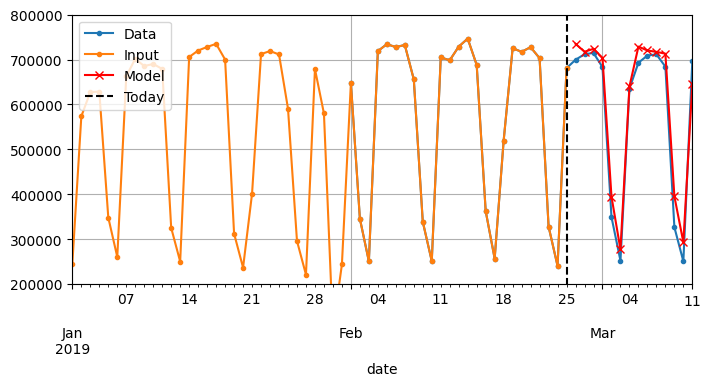

In [65]:
fig, ax = plt.subplots(figsize=(8, 3.5))
(rail_valid * 1e6)["2019-02-01":"2019-03-11"].plot(label="Data", marker=".", ax=ax)
(mulvar_valid[0:seq_length]['rail']*1e6).plot(label="Input", marker=".", ax=ax)
(y_aheadP * 1e6).plot(label="Model", grid=True, marker="x", color="r", ax=ax)

ax.vlines("2019-02-25", 0, 1e6, color="k", linestyle="--", label="Today")
ax.set_ylim([200_000, 800_000])
plt.legend(loc="upper left")
plt.show()

## B) sequence-to-sequence

Now let's create an RNN that predicts the next 14 steps at each time step. That is, instead of just forecasting time steps 56 to 69 based on time steps 0 to 55, it will forecast time steps 1 to 14 at time step 0, then time steps 2 to 15 at time step 1, and so on, and finally it will forecast time steps 56 to 69 at the last time step. Notice that the model is causal: when it makes predictions at any time step, it can only see past time steps.

**Data preparation**

In [66]:
class TimeseriesDataset(Dataset):
    """
    PyTorch Dataset for creating sequence-to-sequence data.

    Takes a time series dataset and creates windows suitable for
    predicting 'ahead' future steps based on 'seq_length' past steps.
    """
    def __init__(self, data, seq_length, ahead, target_col):
        """
        Args:
            data (pd.DataFrame or np.ndarray): The time series data (time steps, features).
            seq_length (int): Length of the input sequence (X).
            ahead (int): Number of steps ahead to predict (length of y).
            target_col (int): Index of the column to be predicted in the target sequence y.
        """
        super().__init__()
        self.seq_length = seq_length
        self.ahead = ahead
        self.target_col = target_col
        self.window_size = seq_length + ahead

        # Convert data to a PyTorch tensor
        if isinstance(data, pd.DataFrame):
            data = data.values
        # Ensure data is float32, common for PyTorch models
        self.data = torch.tensor(data, dtype=torch.float32)
        self.num_features = self.data.shape[1]

        # Calculate the number of possible sequences
        self.num_samples = len(self.data) - self.window_size + 1
        if self.num_samples < 1:
             raise ValueError(f"Data length ({len(self.data)}) is too small "
                              f"for seq_length ({seq_length}) + ahead ({ahead}).")


    def __len__(self):
        """Returns the total number of samples (sequences) in the dataset."""
        return self.num_samples

    def __getitem__(self, index):
        """
        Retrieves a single sample (input sequence X and target sequence y).

        Args:
            index (int): Index of the sample to retrieve.

        Returns:
            tuple: (torch.Tensor, torch.Tensor) where:
                   - X is the input sequence, shape (seq_length, num_features)
                   - y is the target sequence, shape (ahead, 1) # Predicting 1 feature
        """
        if index < 0 or index >= self.num_samples:
            raise IndexError("Index out of bounds")

        # Define the window boundaries
        start_idx = index
        end_idx = index + self.window_size

        # Slice the full window
        window = self.data[start_idx:end_idx] # Shape: (window_size, num_features)

        # Input sequence X: first 'seq_length' steps, all features
        x = window[:self.seq_length] # Shape: (seq_length, num_features)

        # Target sequence y: last 'ahead' steps, only the target column
        # We slice starting from seq_length index up to the end of the window
        # We select only the target_col, keeping it as a 2D tensor (ahead, 1)
        y = window[self.seq_length:, [self.target_col]] # Shape: (ahead, 1)

        return x, y

In [67]:
# --- Parameters ---
SEQ_LENGTH = 56  # Length of input sequence
AHEAD = 14       # How many steps ahead to predict
TARGET_COL = 1   # Index of the target variable in the dataframe/array
BATCH_SIZE = 32
SEED = 42

train_dataset = TimeseriesDataset(
    data=mulvar_train,
    seq_length=SEQ_LENGTH,
    ahead=AHEAD,
    target_col=TARGET_COL
)

valid_dataset = TimeseriesDataset(
    data=mulvar_valid,
    seq_length=SEQ_LENGTH,
    ahead=AHEAD,
    target_col=TARGET_COL
)

# --- Create DataLoaders ---
# Set generator for reproducible shuffling if needed
generator = torch.Generator().manual_seed(SEED)

seq2seq_train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    generator=generator # Use generator for reproducible shuffling
)

seq2seq_valid_loader = DataLoader(
    dataset=valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False # No need to shuffle validation data
)

Example batch from training loader:
X batch shape: torch.Size([32, 56, 5])
y batch shape: torch.Size([32, 14, 1])

Example batch from validation loader:
X val batch shape: torch.Size([32, 56, 5])
y val batch shape: torch.Size([32, 14, 1])


**Model and training**

Keras-equivalent:

```python
seq2seq_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
    # equivalent: tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(14))
    # also equivalent: tf.keras.layers.Conv1D(14, kernel_size=1)
])
```

In [73]:
class Seq2SeqRNN(nn.Module):
    def __init__(self, input_size=5, hidden_size=32, num_target_features=1, ahead=14):
        """
        Args:
            input_size (int): Number of features in the input sequence.
            hidden_size (int): Number of units in the RNN hidden state.
            num_target_features (int): Number of features in the target variable (usually 1).
            ahead (int): Number of steps ahead to predict.
        """
        super().__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.num_target_features = num_target_features
        self.ahead = ahead

        self.rnn = nn.RNN(
            input_size=self.input_size,
            hidden_size=self.hidden_size,
            num_layers=1,
            batch_first=True,
            nonlinearity='tanh'
        )

        self.linear = nn.Linear(
            in_features=self.hidden_size,
            out_features=self.num_target_features # Output 1 feature per step
        )

    def forward(self, x):
        """
        Forward pass for forecasting.

        Args:
            x (torch.Tensor): Input tensor (batch_size, seq_length, input_size)

        Returns:
            torch.Tensor: Output tensor (batch_size, ahead, num_target_features)
        """
        rnn_output, _ = self.rnn(x)

        output_sequence = self.linear(rnn_output)

        # --- Adaptation for Forecasting ---
        # Select the *last* 'ahead' time steps from the output sequence
        # This assumes the last 'ahead' outputs correspond to the forecast horizon
        forecast = output_sequence[:, -self.ahead:, :]
        # forecast shape: (batch, ahead, num_target_features)

        return forecast

seq2seq_model = Seq2SeqRNN(
    input_size=5,
    hidden_size=32,
    num_target_features=1,
    ahead=14
)

In [74]:
%time mine.train_save(seq2seq_model, in_colab, "seq2seq.pth", seq2seq_train_loader, seq2seq_valid_loader, 0.1, mine.fit_and_evaluate_mulvar)

Epoch 139/500, Validation MAE: 0.038728
   -0.86  ┤
   -0.92  ┤
   -0.98  ┤
   -1.04  ┤
   -1.10  ┤
   -1.16  ┤
   -1.22  ┤                                                                                       ╭╮
   -1.28  ┤                       ╭╮                                                              ││
   -1.34  ┤  ╭╮    ╭╮ ╭╮╭╮        ││           ╭╮                     ╭╮  ╭╮    ╭╮                ││
   -1.40  ┤  ││╭─╮╭╯│ ││││   ╭╮╭╮╭╯│     ╭─╮╭╮ ││      ╭╮ ╭╮╭╮╭╮      │╰╮╭╯╰╮   ││             ╭╮ ││         ╭
   -1.45  ┼──╯╰╯ ╰╯ ╰─╯╰╯╰───╯╰╯╰╯ ╰─────╯ ╰╯╰─╯╰──────╯╰─╯╰╯╰╯╰──────╯ ╰╯  ╰───╯╰─────────────╯╰─╯╰─────────╯
   -1.51  ┤
Early stopping triggered at epoch 139
Saving weights to disk
CPU times: user 42.8 s, sys: 197 ms, total: 43 s
Wall time: 43.4 s


**Inference**

Remember that for each time, the model produces 14 predictions in the future.

In [85]:
y_seq=mine.forecast_ahead(seq_length, mulvar_valid[:seq_length], seq2seq_model)

# convert to pandas TS
y_seqP = pd.Series(y_seq[0,:, 0], index=pd.date_range("2019-02-26", "2019-03-11"))

This is the prediction for the last time step.

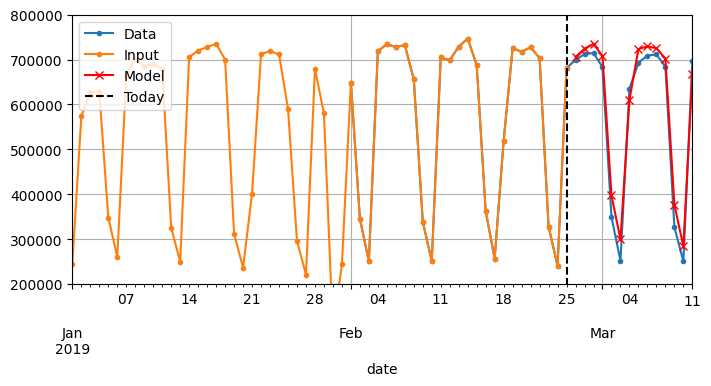

In [86]:
fig, ax = plt.subplots(figsize=(8, 3.5))
(rail_valid * 1e6)["2019-02-01":"2019-03-11"].plot(label="Data", marker=".", ax=ax)
(mulvar_valid[0:seq_length]['rail']*1e6).plot(label="Input", marker=".", ax=ax)
(y_seqP * 1e6).plot(label="Model", grid=True, marker="x", color="r", ax=ax)

ax.vlines("2019-02-25", 0, 1e6, color="k", linestyle="--", label="Today")
ax.set_ylim([200_000, 800_000])
plt.legend(loc="upper left")
plt.show()

# Uncertainty band

When forecasting time series, it is often useful to have some error
bars along with your predictions. For this, one approach is to use
MC dropout, introduced in Chapter 11: use `recurrent_dropout`
during training, then keep dropout active at inference time by
calling the model using `model(X, training=True)`. Repeat this
several times to get multiple slightly different forecasts, then compute the mean and standard deviation of these predictions for each
time step.

Train with `recurrent_dropout`.

In [ ]:
%%time
if in_colab:
    model_file='/content/drive/MyDrive/Colab Notebooks/models/ahead_errors.keras'
else:
    model_file=Path() / "models" / "ahead_errors.keras"

if not os.path.exists(model_file): # train
    tf.random.set_seed(42)

    ahead_errors = tf.keras.Sequential([
      tf.keras.layers.SimpleRNN(32, input_shape=[None, 5], recurrent_dropout=0.2), # <=======
      tf.keras.layers.Dense(14)
    ])

    # extra code – compiles, fits, and evaluates the model, like earlier
    fit_and_evaluate(ahead_model, ahead_train_ds, ahead_valid_ds, learning_rate=0.02)

    # Save weights to Google Drive
    ahead_errors.save(model_file)
else: # loads model from disk
    ahead_errors=tf.keras.models.load_model(model_file)

CPU times: user 34.4 ms, sys: 1.91 ms, total: 36.3 ms
Wall time: 40.7 ms


Input sequence

In [ ]:
X = mulvar_valid.to_numpy()[np.newaxis, :seq_length]  # shape [1, 56, 5]

Generates distribution of predictions

In [ ]:
# how many predictions will be generated
n=100

# generates matrix with ensemble of predictions
# rows: different predictions
# columns: time
for i in tqdm(range(n)):
  if i==0:
    ensemble = ahead_errors(X, training=True)[0, :]
  else:
    ensemble=np.vstack((ensemble,ahead_errors(X, training=True)[0,:]))


100%|██████████| 100/100 [00:15<00:00,  6.28it/s]


Computes median and std. deviation of ensemble

In [ ]:
ts_median=np.median(ensemble, axis=0)
ts_std=np.std(ensemble, axis=0)
ts_up=ts_median+ts_std
ts_down=ts_median-ts_std

Wrapper to convert to pandas TS

In [ ]:
tos=lambda ts:pd.Series(ts, index=pd.date_range("2019-02-26", "2019-03-11"))

Here is the confidence band

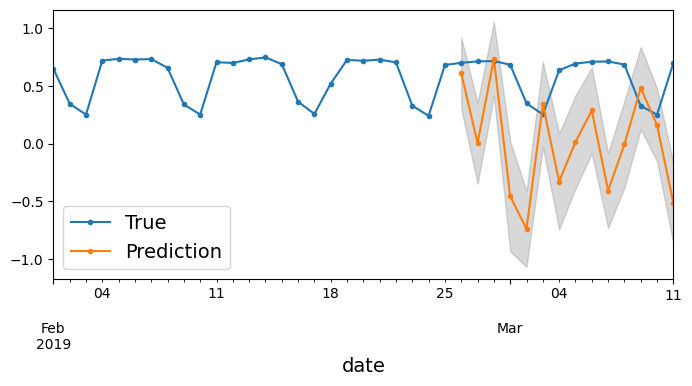

In [ ]:
fig, ax = plt.subplots(figsize=(8, 3.5))

rail_valid["2019-02-01":"2019-03-11"].plot(label="True", marker=".", ax=ax)

# Fill the area between the series
plt.fill_between(tos(ts_median).index, ts_down, ts_up, color='gray', alpha=0.3)

tos(ts_median).plot(marker='.', ax=ax, label='Prediction')
plt.legend()


100%|██████████| 100/100 [00:01<00:00, 60.01it/s]


<Axes: xlabel='date'>

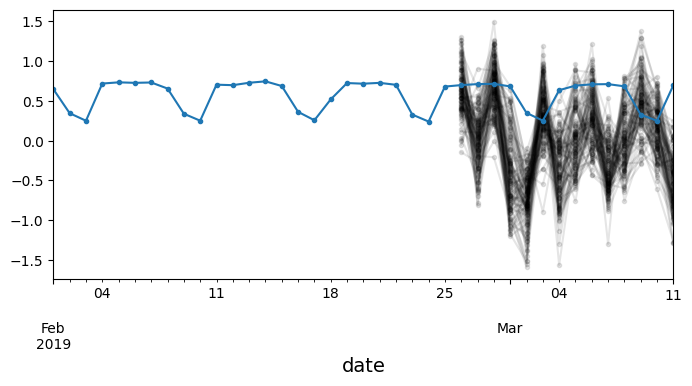

In [ ]:
fig, ax = plt.subplots(figsize=(8, 3.5))

for ts in tqdm(ensemble):
  tos(ts).plot(marker='.', ax=ax, alpha=0.1, color='k')

rail_valid["2019-02-01":"2019-03-11"].plot(label="True", marker=".", ax=ax)


<div class="alert alert-warning"><h4>ISSUE</h4><p>
The posteriors above do not make any fucking sense.
</p></div>

# TODO

- [ ] Layer normalization